In [1]:
import datetime as dt
import glob
import math
import re
import warnings
from pathlib import Path
import folium
import geopandas as gpd
import holidays
import joblib
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import seaborn as sns
from folium.plugins import HeatMap
from IPython.display import display
from matplotlib.ticker import FuncFormatter
from pandas.tseries.offsets import MonthEnd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, RobustScaler

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 160)

<div style="border: 2px solid #FFC107; background-color:#e0e0e0; border-radius: 6px; padding: 14px; line-height:1.7; font-size: 110%; color:#000">  
The <b>schema validation step</b> confirmed that all 2024 parquet files have an identical column structure, while the 2025 files introduced an <b>extra field: `cbd_congestion_fee`</b>. This is an expected schema drift because new fee components were added to NYC taxi data in later years. Importantly, no files were missing required columns. Only additional ones appeared.
<br><br>
In the <b>column normalization step</b>, I standardized all files to a clean schema of <b>11 core features</b> (for example, `pickup/dropoff times`, `locations`, `trip_distance`, `payment_type`, `total_amount`). The <b>`cbd_congestion_fee`</b> field was removed because it was an extra column not present in earlier years. Other fee components such as `fare_amount`, `tip_amount`, `tolls_amount`, and `mta_tax` were <b>dropped to avoid data leakage</b>, since they directly contribute to the target variable `total_amount`.
</div>

In [2]:
RAW = Path("../data/raw")
files = sorted(glob.glob(str(RAW / "*.parquet")))

schemas = {}
for fp in files:
    pf = pq.ParquetFile(fp)
    cols = list(pf.schema.names)
    schemas[Path(fp).name] = cols

# Take the first file as schema reference
ref_file, ref_cols = next(iter(schemas.items()))
print(f"Reference file: {ref_file}\n")

for fname, cols in schemas.items():
    if cols != ref_cols:
        missing = set(ref_cols) - set(cols)
        extra = set(cols) - set(ref_cols)
        print(f"⚠️ {fname} differs:")
        if missing:
            print("   Missing:", sorted(missing))
        if extra:
            print("   Extra:", sorted(extra))
    else:
        print(f"✓ {fname} matches schema")

Reference file: yellow_tripdata_2024-01.parquet

✓ yellow_tripdata_2024-01.parquet matches schema
✓ yellow_tripdata_2024-02.parquet matches schema
✓ yellow_tripdata_2024-03.parquet matches schema
✓ yellow_tripdata_2024-04.parquet matches schema
✓ yellow_tripdata_2024-05.parquet matches schema
✓ yellow_tripdata_2024-06.parquet matches schema
✓ yellow_tripdata_2024-07.parquet matches schema
✓ yellow_tripdata_2024-08.parquet matches schema
✓ yellow_tripdata_2024-09.parquet matches schema
✓ yellow_tripdata_2024-10.parquet matches schema
✓ yellow_tripdata_2024-11.parquet matches schema
✓ yellow_tripdata_2024-12.parquet matches schema
⚠️ yellow_tripdata_2025-01.parquet differs:
   Extra: ['cbd_congestion_fee']
⚠️ yellow_tripdata_2025-02.parquet differs:
   Extra: ['cbd_congestion_fee']
⚠️ yellow_tripdata_2025-03.parquet differs:
   Extra: ['cbd_congestion_fee']
⚠️ yellow_tripdata_2025-04.parquet differs:
   Extra: ['cbd_congestion_fee']
⚠️ yellow_tripdata_2025-05.parquet differs:
   Extra: [

In [3]:
RAW = Path("../data/raw")
OUT = Path("../data/columns_normalized")
OUT.mkdir(parents=True, exist_ok=True)

files = sorted(glob.glob(str(RAW / "*.parquet")))

# Columns to drop
DROP_COLS = {
    "cbd_congestion_fee",
    "fare_amount",
    "extra",
    "mta_tax",
    "tip_amount",
    "tolls_amount",
    "improvement_surcharge",
    "congestion_surcharge",
    "airport_fee",
}

# Use first file as reference, excluding DROP_COLS
ref_pf = pq.ParquetFile(files[0])
KEEP_COLS = [c for c in ref_pf.schema.names if c.lower() not in DROP_COLS]

print(f"Reference KEEP_COLS ({len(KEEP_COLS)}): {KEEP_COLS}\n")

for fp in files:
    schema_cols = set(pq.ParquetFile(fp).schema.names)

    # Only keep desired columns that exist in this file
    cols_to_read = [c for c in KEEP_COLS if c in schema_cols]

    df = pd.read_parquet(fp, columns=cols_to_read)

    # Add missing KEEP_COLS back as NA
    missing = [c for c in KEEP_COLS if c not in df.columns]
    for c in missing:
        df[c] = pd.NA

    # Reorder to KEEP_COLS
    df = df[KEEP_COLS]

    # Save processed copy
    out_fp = OUT / Path(fp).name
    df.to_parquet(out_fp, index=False, compression="zstd")

    print(f"✔ {Path(fp).name}: rows={len(df):,} → saved {out_fp}")

Reference KEEP_COLS (11): ['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'total_amount']

✔ yellow_tripdata_2024-01.parquet: rows=2,964,624 → saved ..\data\columns_normalized\yellow_tripdata_2024-01.parquet
✔ yellow_tripdata_2024-02.parquet: rows=3,007,526 → saved ..\data\columns_normalized\yellow_tripdata_2024-02.parquet
✔ yellow_tripdata_2024-03.parquet: rows=3,582,628 → saved ..\data\columns_normalized\yellow_tripdata_2024-03.parquet
✔ yellow_tripdata_2024-04.parquet: rows=3,514,289 → saved ..\data\columns_normalized\yellow_tripdata_2024-04.parquet
✔ yellow_tripdata_2024-05.parquet: rows=3,723,833 → saved ..\data\columns_normalized\yellow_tripdata_2024-05.parquet
✔ yellow_tripdata_2024-06.parquet: rows=3,539,193 → saved ..\data\columns_normalized\yellow_tripdata_2024-06.parquet
✔ yellow_tripdata_2024-07.parquet: rows=3,076,903 → saved ..\data\columns

<div style="border: 2px solid #FFC107; background-color:#e0e0e0; border-radius: 6px; padding: 14px; line-height:1.7; font-size: 110%; color:#000">
The <b>month boundary filter</b> enforces temporal integrity by keeping only trips whose <b>pickup timestamp</b> falls within the expected calendar month. Any value that does not conform to the year–month of the file is excluded. Invalid timestamps are converted to <b>NaT (Not a Time)</b>
<br><br>
Across all files, <b>0 NaT pickups</b> were detected, and the proportion of rows dropped per month was extremely small (<b>about 0.0002% to 0.0017%</b>). These removals correspond to trips that spilled outside the official month boundaries or inconsistencies.  
</div>

In [4]:
src = Path("../data/columns_normalized")
dst = Path("../data/month_filtered")
dst.mkdir(parents=True, exist_ok=True)


files = sorted(glob.glob(str(src / "yellow_tripdata_20*.parquet")))


def parse_year_month(fp: str):
    m = re.search(r"(\d{4})-(\d{2})", Path(fp).name)
    if not m:
        raise ValueError(f"Cannot parse YYYY-MM from: {fp}")
    return int(m.group(1)), int(m.group(2))


summary = []
for fp in files:
    yy, mm = parse_year_month(fp)
    month_start = pd.Timestamp(yy, mm, 1)
    next_month_start = (month_start + MonthEnd(1)) + pd.Timedelta(days=1)

    df = pd.read_parquet(fp)
    df["tpep_pickup_datetime"] = pd.to_datetime(
        df["tpep_pickup_datetime"], errors="coerce"
    )

    n_total = len(df)
    n_nat = df["tpep_pickup_datetime"].isna().sum()

    mask_in = (df["tpep_pickup_datetime"] >= month_start) & (
        df["tpep_pickup_datetime"] < next_month_start
    )
    df_clean = df.loc[mask_in].copy()

    n_in = len(df_clean)
    n_out = n_total - n_in
    pct_out = (n_out / n_total * 100) if n_total else 0.0

    out_fp = dst / Path(fp).name
    df_clean.to_parquet(out_fp, index=False)

    print(
        f"{Path(fp).name}: total={n_total:,}  kept={n_in:,}  dropped={n_out:,} ({pct_out:.4f}%)  NaT_pickup={n_nat:,}"
    )
    summary.append((Path(fp).name, n_total, n_in, n_out, n_nat))

print(f"\n[DONE] Saved filtered files to: {dst}")

yellow_tripdata_2024-01.parquet: total=2,964,624  kept=2,964,606  dropped=18 (0.0006%)  NaT_pickup=0
yellow_tripdata_2024-02.parquet: total=3,007,526  kept=3,007,511  dropped=15 (0.0005%)  NaT_pickup=0
yellow_tripdata_2024-03.parquet: total=3,582,628  kept=3,582,605  dropped=23 (0.0006%)  NaT_pickup=0
yellow_tripdata_2024-04.parquet: total=3,514,289  kept=3,514,280  dropped=9 (0.0003%)  NaT_pickup=0
yellow_tripdata_2024-05.parquet: total=3,723,833  kept=3,723,800  dropped=33 (0.0009%)  NaT_pickup=0
yellow_tripdata_2024-06.parquet: total=3,539,193  kept=3,539,142  dropped=51 (0.0014%)  NaT_pickup=0
yellow_tripdata_2024-07.parquet: total=3,076,903  kept=3,076,856  dropped=47 (0.0015%)  NaT_pickup=0
yellow_tripdata_2024-08.parquet: total=2,979,183  kept=2,979,132  dropped=51 (0.0017%)  NaT_pickup=0
yellow_tripdata_2024-09.parquet: total=3,633,030  kept=3,632,981  dropped=49 (0.0013%)  NaT_pickup=0
yellow_tripdata_2024-10.parquet: total=3,833,771  kept=3,833,731  dropped=40 (0.0010%)  NaT_

In [5]:
df = pd.read_parquet("../data/month_filtered/yellow_tripdata_2024-01.parquet")
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,total_amount
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,22.70
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,18.75
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,31.30
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,17.00
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,16.10


<div style="border: 2px solid #FFC107; background-color:#e0e0e0; border-radius: 6px; padding: 14px; line-height:1.7; font-size: 110%; color:#000">
The <b>missingness audit</b> checks a 25,000 row sample from each month and focuses on three columns: <b>passenger_count</b>, <b>RatecodeID</b>, and <b>store_and_fwd_flag</b>. These often have missing values at the same time. The code confirms that when one of these columns is missing the other two are also missing, which is shown as <b>"co-missing OK"</b>. The figure title also reports the <b>"Drop on trio proxy"</b>, which is the percentage of rows that would be lost if we removed all rows where this trio is missing. For example about <b>4.6%</b> in 2024-01 and about <b>11.9%</b> in 2024-03.  
<br><br>
This means the three columns have a clear and consistent missing pattern. They can be handled together either by dropping those rows or by applying the same imputation rule to all three. The numbers come from a sample, so the exact values in the full dataset may be slightly different.
</div>

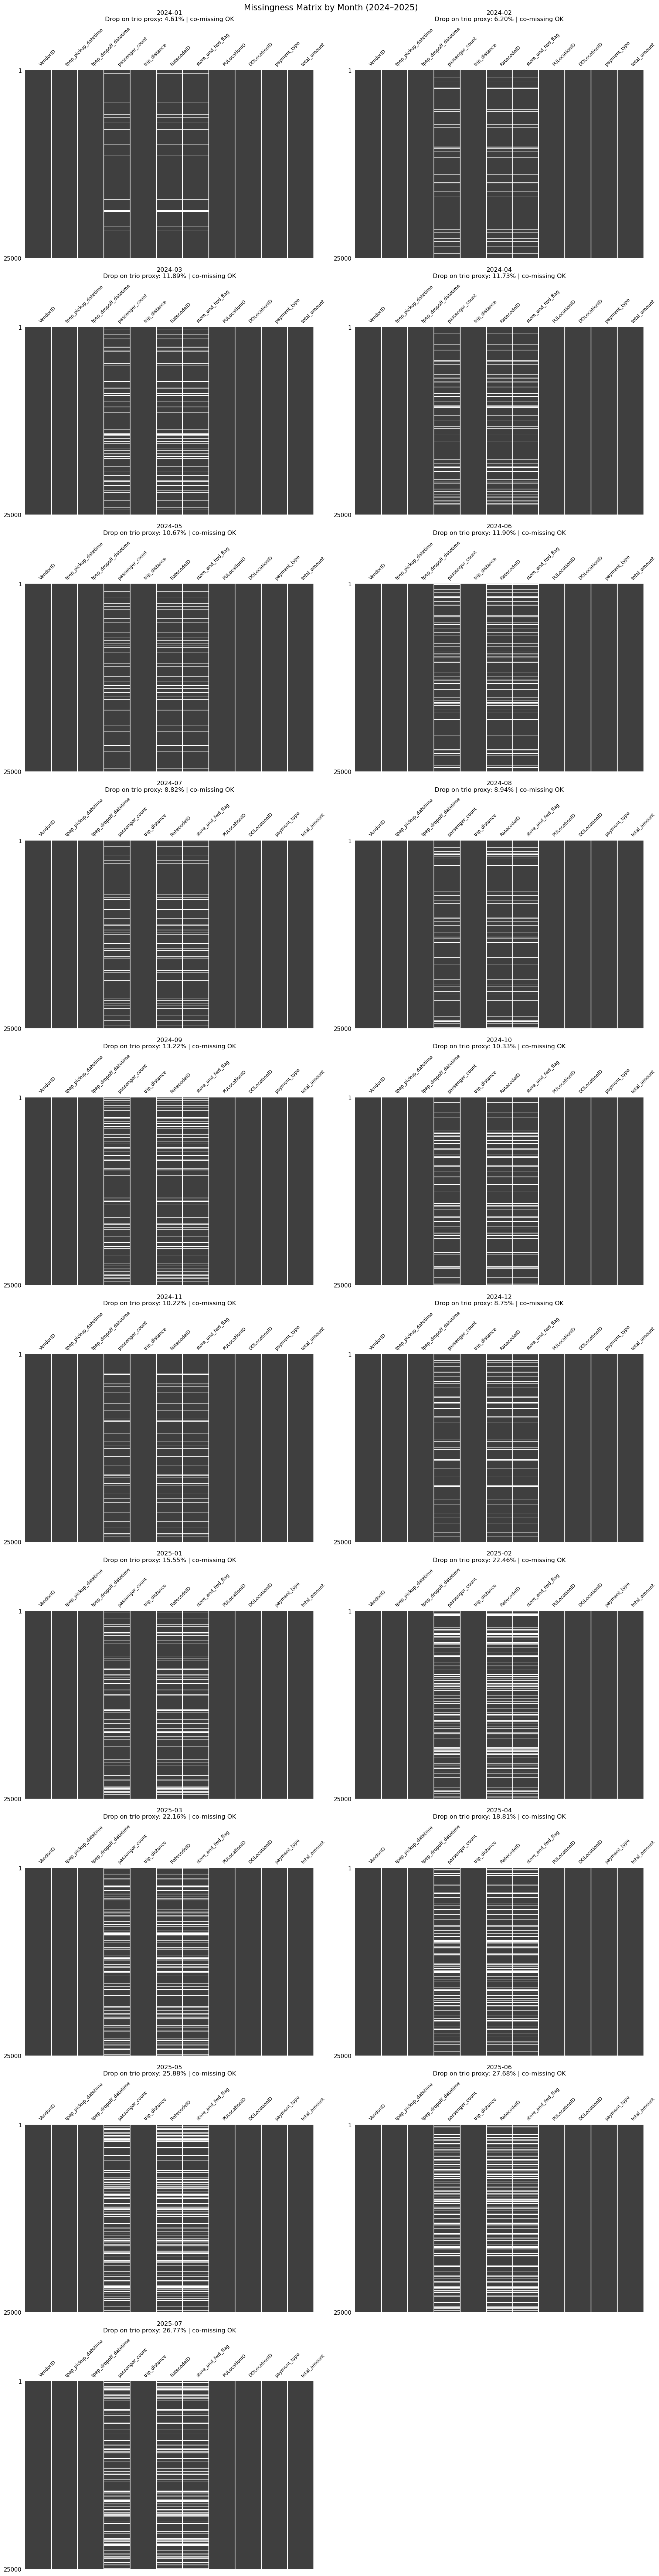

In [6]:
src = Path("../data/month_filtered")

files = sorted(glob.glob(str(src / "yellow_tripdata_20*.parquet")))


N_COLS = 2
ROW_SAMPLE = 25_000
COLUMNS = None
CO_NA_COLS = ["passenger_count", "RatecodeID", "store_and_fwd_flag"]


if not files:
    raise FileNotFoundError(f"No parquet files found under {RAW_DIR}")

n = len(files)
n_rows = math.ceil(n / N_COLS)
fig, axes = plt.subplots(
    n_rows, N_COLS, figsize=(N_COLS * 9, n_rows * 7), squeeze=False
)
axes = axes.ravel()

ym_re = re.compile(r"(\d{4}-\d{2})")

for i, fp in enumerate(files):
    try:
        df = pd.read_parquet(fp, columns=COLUMNS) if COLUMNS else pd.read_parquet(fp)
    except Exception as e:
        warnings.warn(f"Failed to read {Path(fp).name}: {e}")
        axes[i].axis("off")
        continue

    if ROW_SAMPLE and len(df) > ROW_SAMPLE:
        df = df.sample(n=ROW_SAMPLE, random_state=42)

    trio = [c for c in CO_NA_COLS if c in df.columns]
    co_msg = ""
    n0 = len(df)

    if len(trio) == 3:
        m = df[trio].isna()
        try:
            same_rows = (m.nunique(axis=1) == 1).all()
            assert (
                same_rows
            ), "Rows show partial NaNs within the trio (not all-or-nothing)."
            assert m.iloc[:, 0].equals(m.any(axis=1)), "Trio NaN mask mismatch."
            co_msg = "co-missing OK"
        except AssertionError as e:
            co_msg = f"{str(e)}"
            warnings.warn(f"{Path(fp).name}: {co_msg}")

        n1 = len(df.dropna(subset=trio))
        lost = n0 - n1
    else:
        n1 = len(df.dropna())
        lost = n0 - n1
        co_msg = "ℹ trio incomplete; used dropna(all)"

    pct_lost = (lost / n0 * 100) if n0 else 0.0

    ax = axes[i]
    try:
        msno.matrix(
            df if COLUMNS is None else df[COLUMNS], ax=ax, sparkline=False, fontsize=9
        )
    except Exception as e:
        warnings.warn(f"missingno failed on {Path(fp).name}: {e}")
        ax.axis("off")

    mo = ym_re.search(fp)
    title = mo.group(1) if mo else Path(fp).stem
    ax.set_title(f"{title}\nDrop on trio proxy: {pct_lost:.2f}% | {co_msg}", pad=10)

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

fig.suptitle("Missingness Matrix by Month (2024–2025)", fontsize=16, y=0.995)
plt.tight_layout()
plt.show()

<div style="border: 2px solid #FFC107; background-color:#e0e0e0; border-radius: 6px; padding: 14px; line-height:1.7; font-size:110%; color:#000">
The <b>dropna-on-trio audit</b> removes rows where <b>passenger_count</b>, <b>RatecodeID</b>, and <b>store_and_fwd_flag</b> are co-missing. The share dropped is modest in 2024 (<b>about 5% to 13%</b>) and much higher in 2025 (<b>about 16% to 28%</b>). After dropping the trio, <b>total_amount</b> mean tends to rise slightly while <b>trip_distance</b> mean drops sharply in many 2025 months (for example <b>7.65 → 4.03</b> in 2025-05). This suggests the removed rows are more common among longer trips and lower average fares per trip, so missingness is <b>not random</b>.  
<br><br>
To quantify shift, the code reports <b>TVD</b> (Total Variation Distance, range 0 to 1) between pre-drop and post-drop distributions. Location shifts reach about <b>0.10</b> for <b>PULocationID</b> and <b>0.07</b> for <b>DOLocationID</b>. Pickup hour shifts reach about <b>0.05</b>. The largest movement appears in <b>payment_type</b> with TVD up to <b>0.28</b>. These values confirm that dropping the trio changes the data mix by <b>zone</b>, <b>time</b>, and <b>payment behavior</b>.  
<br><br>
<b>Implication for preprocessing</b>: the trio can be dropped safely in 2024 with limited bias. In 2025 the loss is large and correlates with longer trips and payment mix, so pure dropping would bias the training set. Prefer <b>joint imputation</b> or a <b>modeling strategy that tolerates trio missingness</b>, and keep the TVD table as a data card that documents the shift risk.
</div>

In [7]:
src = Path("../data/month_filtered")

files = sorted(glob.glob(str(src / "yellow_tripdata_20*.parquet")))

if not files:
    raise FileNotFoundError(f"No parquet files under {SRC_DIR}")

DROP_NA_COLS = ["passenger_count", "RatecodeID", "store_and_fwd_flag"]
CHECK_COLS = [
    "total_amount",
    "trip_distance",
    "PULocationID",
    "DOLocationID",
    "payment_type",
]


def tvd(a: pd.Series, b: pd.Series) -> float:
    """Total Variation Distance between two (categorical or discretized) distributions."""
    p = a.value_counts(normalize=True, dropna=False)
    q = b.value_counts(normalize=True, dropna=False)
    return 0.5 * (p.subtract(q, fill_value=0).abs().sum())


ym_re = re.compile(r"(\d{4}-\d{2})")
rows = []

for fp in files:
    df = pd.read_parquet(fp)
    n_total = len(df)

    trio_present = [c for c in DROP_NA_COLS if c in df.columns]
    df_clean = df.dropna(subset=trio_present) if trio_present else df.copy()
    n_clean = len(df_clean)
    pct_dropped = ((n_total - n_clean) / n_total * 100.0) if n_total else 0.0

    ym = ym_re.search(Path(fp).name).group(1)

    ta_mean_all = df["total_amount"].mean() if "total_amount" in df.columns else pd.NA
    ta_mean_clean = (
        df_clean["total_amount"].mean() if "total_amount" in df_clean.columns else pd.NA
    )
    td_mean_all = df["trip_distance"].mean() if "trip_distance" in df.columns else pd.NA
    td_mean_clean = (
        df_clean["trip_distance"].mean()
        if "trip_distance" in df_clean.columns
        else pd.NA
    )

    hour_all = pd.to_datetime(
        df["tpep_pickup_datetime"], errors="coerce", utc=True
    ).dt.hour
    hour_clean = pd.to_datetime(
        df_clean["tpep_pickup_datetime"], errors="coerce", utc=True
    ).dt.hour

    # Distribution shifts (TVD)
    tvd_pu = (
        tvd(df["PULocationID"], df_clean["PULocationID"])
        if "PULocationID" in df.columns
        else pd.NA
    )
    tvd_do = (
        tvd(df["DOLocationID"], df_clean["DOLocationID"])
        if "DOLocationID" in df.columns
        else pd.NA
    )
    tvd_hour = tvd(hour_all, hour_clean)
    tvd_pay = (
        tvd(df["payment_type"], df_clean["payment_type"])
        if "payment_type" in df.columns
        else pd.NA
    )

    rows.append(
        {
            "month": ym,
            "rows_total": n_total,
            "rows_after_dropna": n_clean,
            "pct_dropped": round(pct_dropped, 2),
            "total_amount_mean_all": (
                round(ta_mean_all, 2) if ta_mean_all is not pd.NA else pd.NA
            ),
            "total_amount_mean_clean": (
                round(ta_mean_clean, 2) if ta_mean_clean is not pd.NA else pd.NA
            ),
            "trip_dist_mean_all": (
                round(td_mean_all, 3) if td_mean_all is not pd.NA else pd.NA
            ),
            "trip_dist_mean_clean": (
                round(td_mean_clean, 3) if td_mean_clean is not pd.NA else pd.NA
            ),
            "TVD_PULocationID": round(tvd_pu, 3) if tvd_pu is not pd.NA else pd.NA,
            "TVD_DOLocationID": round(tvd_do, 3) if tvd_do is not pd.NA else pd.NA,
            "TVD_hour": round(tvd_hour, 3),
            "TVD_payment_type": round(tvd_pay, 3) if tvd_pay is not pd.NA else pd.NA,
        }
    )

summary = pd.DataFrame(rows).sort_values("month").reset_index(drop=True)
display(summary)

,month,rows_total,rows_after_dropna,pct_dropped,total_amount_mean_all,total_amount_mean_clean,trip_dist_mean_all,trip_dist_mean_clean,TVD_PULocationID,TVD_DOLocationID,TVD_hour,TVD_payment_type
0,2024-01,2964606,2824444,4.73,26.80,26.85,3.652,3.254,0.012,0.006,0.009,0.047
1,2024-02,3007511,2821901,6.17,26.62,26.79,3.861,3.368,0.015,0.009,0.014,0.062
2,2024-03,3582605,3156415,11.90,27.12,27.63,4.517,3.529,0.032,0.020,0.027,0.119
3,2024-04,3514280,3105704,11.63,27.49,28.00,5.284,3.561,0.031,0.018,0.028,0.116
4,2024-05,3723800,3319134,10.87,28.37,28.70,5.367,3.421,0.032,0.016,0.016,0.109
5,2024-06,3539142,3128361,11.61,27.93,28.30,5.222,3.760,0.033,0.018,0.017,0.116
6,2024-07,3076856,2797867,9.07,28.09,28.50,5.112,3.684,0.025,0.013,0.017,0.091
7,2024-08,2979132,2720465,8.68,28.27,28.64,4.945,3.834,0.025,0.013,0.014,0.087
8,2024-09,3632981,3149250,13.31,28.54,29.25,5.741,3.535,0.039,0.023,0.020,0.133
9,2024-10,3833731,3439836,10.27,28.43,28.95,5.124,3.525,0.030,0.017,0.018,0.103


<div style="border: 2px solid #FFC107; background-color:#e0e0e0; border-radius: 6px; padding: 14px; line-height:1.7; font-size:110%; color:#000">
The <b>missing handling step</b> applies a <b>two-path policy</b> for the trio <b>passenger_count</b>, <b>RatecodeID</b>, and <b>store_and_fwd_flag</b>.  
For <b>2024</b> files, rows with the trio missing were <b>dropped</b>. Row counts decreased in each month, for example 2024-01 <b>2,964,606 → 2,824,444</b> and 2024-09 <b>3,632,981 → 3,149,250</b>. This choice fits the earlier audit that showed moderate drop rates in 2024 and limited shift risk.  
<br><br>
For <b>2025</b> files, the trio was <b>imputed by mode</b> to avoid large data loss and bias. The code fills <b>passenger_count</b> with the sample mode (fallback <b>1</b>), <b>RatecodeID</b> with its mode (fallback <b>1</b>), and <b>store_and_fwd_flag</b> with its mode (fallback <b>"N"</b>). Row counts stay the same, for example 2025-05 <b>4,591,821 → 4,591,821</b>. Mode imputation is suitable here because these fields are discrete and the mode matches the most common operational values.  
</div>

In [8]:
SRC = Path("../data/month_filtered")
DST = Path("../data/missing_handled")
DST.mkdir(parents=True, exist_ok=True)

files = sorted(
    glob.glob(str(SRC / "yellow_tripdata_2024-*.parquet"))
    + glob.glob(str(SRC / "yellow_tripdata_2025-*.parquet"))
)
if not files:
    raise FileNotFoundError(f"No parquet files in {SRC}")

DROP_NA_COLS = ["passenger_count", "RatecodeID", "store_and_fwd_flag"]


def file_year(name: str) -> int:
    m = re.search(r"(\d{4})-(\d{2})", name)
    if not m:
        raise ValueError(f"Cannot parse YYYY-MM from filename: {name}")
    return int(m.group(1))


for fp_str in files:
    fp = Path(fp_str)
    year = file_year(fp.name)
    df = pd.read_parquet(fp)

    n0 = len(df)

    if year == 2024:
        cols_present = [c for c in DROP_NA_COLS if c in df.columns]
        df = df.dropna(subset=cols_present) if cols_present else df
        action = f"dropped on {cols_present}" if cols_present else "no trio present"
    else:
        if "passenger_count" in df.columns:
            mode_pc = df["passenger_count"].dropna().mode()
            fill_pc = mode_pc.iloc[0] if not mode_pc.empty else 1
            df["passenger_count"] = df["passenger_count"].fillna(fill_pc)

        if "RatecodeID" in df.columns:
            mode_rate = df["RatecodeID"].dropna().mode()
            fill_rate = mode_rate.iloc[0] if not mode_rate.empty else 1
            df["RatecodeID"] = df["RatecodeID"].fillna(fill_rate)

        if "store_and_fwd_flag" in df.columns:
            mode_saf = df["store_and_fwd_flag"].dropna().mode()
            fill_saf = mode_saf.iloc[0] if not mode_saf.empty else "N"
            df["store_and_fwd_flag"] = df["store_and_fwd_flag"].fillna(fill_saf)

        action = "imputed by mode (pc, rate, saf)"

    n1 = len(df)
    out_fp = DST / fp.name
    df.to_parquet(out_fp, index=False, compression="zstd")

    print(f"{fp.name}: rows {n0:,} → {n1:,} | {action} | saved {out_fp}")

yellow_tripdata_2024-01.parquet: rows 2,964,606 → 2,824,444 | dropped on ['passenger_count', 'RatecodeID', 'store_and_fwd_flag'] | saved ..\data\missing_handled\yellow_tripdata_2024-01.parquet
yellow_tripdata_2024-02.parquet: rows 3,007,511 → 2,821,901 | dropped on ['passenger_count', 'RatecodeID', 'store_and_fwd_flag'] | saved ..\data\missing_handled\yellow_tripdata_2024-02.parquet
yellow_tripdata_2024-03.parquet: rows 3,582,605 → 3,156,415 | dropped on ['passenger_count', 'RatecodeID', 'store_and_fwd_flag'] | saved ..\data\missing_handled\yellow_tripdata_2024-03.parquet
yellow_tripdata_2024-04.parquet: rows 3,514,280 → 3,105,704 | dropped on ['passenger_count', 'RatecodeID', 'store_and_fwd_flag'] | saved ..\data\missing_handled\yellow_tripdata_2024-04.parquet
yellow_tripdata_2024-05.parquet: rows 3,723,800 → 3,319,134 | dropped on ['passenger_count', 'RatecodeID', 'store_and_fwd_flag'] | saved ..\data\missing_handled\yellow_tripdata_2024-05.parquet
yellow_tripdata_2024-06.parquet: ro

In [9]:
pd.read_parquet("../data/missing_handled/yellow_tripdata_2024-01.parquet").head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,total_amount
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,22.70
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,18.75
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,31.30
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,17.00
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,16.10


<div style="border: 2px solid #FFC107; background-color:#e0e0e0; border-radius: 6px; padding: 14px; line-height:1.7; font-size:110%; color:#000">
The <b>global outlier scan</b> pools month files and computes per-file <b>1% and 99% quantiles</b>, plus <b>min</b> and <b>max</b> for three fields. Results show clear dirty edges: <b>passenger_count</b> has values at <b>0</b> and above <b>9</b>. <b>trip_distance</b> ranges up to <b>397,994.37</b>, which is not realistic for NYC taxi data. <b>total_amount</b> has negatives down to <b>-2,265.45</b> and spikes up to <b>863,380.37</b>. The lower quantiles include zeros for distance and passenger count, and the upper quantiles stay moderate (<b>q99_max</b> around <b>5</b> for passenger count and <b>20.78</b> for distance), which supports trimming extreme values.  
<br><br>
Based on these findings, I set simple <b>rule thresholds</b>: <b>passenger_count</b> in <b>[1, 9]</b>, <b>trip_distance</b> in <b>[0.1, 50]</b>, and <b>total_amount</b> in <b>[1, 250]</b>. The share outside these bands is small but non-trivial: <b>0.86%</b> for passenger count, <b>2.55%</b> for distance, and <b>1.80%</b> for total amount, out of <b>65,060,271</b> rows. These rules remove obvious entry errors and extreme values while keeping the main distribution. This improves model stability, prevents loss spikes in training, and keeps targets and key predictors in practical operating ranges.
</div>


In [10]:
SRC = Path("../data/missing_handled")
COLS = ["passenger_count", "trip_distance", "total_amount"]

files = sorted(glob.glob(str(SRC / "*.parquet")))
if not files:
    raise FileNotFoundError(f"No parquet files in {SRC}")

# Collect per-file quantiles & ranges
q01s, q99s = {c: [] for c in COLS}, {c: [] for c in COLS}
mins, maxs = {c: [] for c in COLS}, {c: [] for c in COLS}

for fp in files:
    df = pd.read_parquet(fp, columns=COLS)
    q = df.quantile([0.01, 0.99])
    for c in COLS:
        q01s[c].append(q.loc[0.01, c])
        q99s[c].append(q.loc[0.99, c])
        mins[c].append(df[c].min(skipna=True))
        maxs[c].append(df[c].max(skipna=True))
    del df

# Aggregate global thresholds
summary_stats = {
    c: {
        "q01_min": min(q01s[c]),
        "q99_max": max(q99s[c]),
        "global_min": min(mins[c]),
        "global_max": max(maxs[c]),
    }
    for c in COLS
}
summary_df = pd.DataFrame(summary_stats).T.round(2)

print("\n=== Global Quantiles & Min/Max Across All Files ===\n")
print(summary_df.to_string())

# Rule-based thresholds
THRESH_LEFT = {"passenger_count": 1, "trip_distance": 0.1, "total_amount": 1}
THRESH_RIGHT = {"passenger_count": 9, "trip_distance": 50, "total_amount": 250}

# Count outliers
outliers, totals = {c: 0 for c in COLS}, {c: 0 for c in COLS}

for fp in files:
    df = pd.read_parquet(fp, columns=COLS)
    for c in COLS:
        totals[c] += df[c].notna().sum()
        outliers[c] += ((df[c] < THRESH_LEFT[c]) | (df[c] > THRESH_RIGHT[c])).sum()
    del df

print("\n=== Outlier Counts (Rule-based thresholds) ===\n")
for c in COLS:
    pct = outliers[c] / totals[c] * 100
    print(
        f"{c}: {outliers[c]:,} / {totals[c]:,} = {pct:.2f}% outside [{THRESH_LEFT[c]}, {THRESH_RIGHT[c]}]"
    )


=== Global Quantiles & Min/Max Across All Files ===

                 q01_min  q99_max  global_min  global_max
passenger_count     0.00     5.00        0.00        9.00
trip_distance       0.00    20.78        0.00   397994.37
total_amount      -18.95   107.49    -2265.45   863380.37

=== Outlier Counts (Rule-based thresholds) ===

passenger_count: 560,879 / 65,060,271 = 0.86% outside [1, 9]
trip_distance: 1,656,570 / 65,060,271 = 2.55% outside [0.1, 50]
total_amount: 1,173,206 / 65,060,271 = 1.80% outside [1, 250]


<div style="border: 2px solid #FFC107; background-color:#e0e0e0; border-radius: 6px; padding: 14px; line-height:1.7; font-size:110%; color:#000">
The <b>outlier removal step</b> keeps rows where <b>passenger_count</b> is in <b>[1, 9]</b>, <b>trip_distance</b> is in <b>[0.1, 50]</b>, and <b>total_amount</b> is in <b>[1, 250]</b>. Values outside these bands are removed. The code also allows <b>NaN</b> to pass the mask, which avoids accidental loss from previously imputed or not applicable fields.
<br><br>
Removal is material in every month. For example 2024-01 removes <b>108,146</b> rows and 2025-05 removes <b>310,013</b> rows. The main drivers are <b>trip_distance &lt; 0.1</b> and <b>total_amount &lt; 1</b>. Counts above the right thresholds are small for <b>passenger_count</b> and modest for <b>trip_distance</b> and <b>total_amount</b>. This matches the earlier global scan that showed many tiny or zero distances and a tail of near zero or negative fares.
<br><br>
This rule set trims clear data entry errors and extreme values while keeping the core distribution. It improves training stability and reduces the risk of the model learning from impossible trips. Because the filters use only feature values and not the target definition logic, the step remains <b>leakage-safe</b>.
</div>


In [11]:
SRC = Path("../data/missing_handled")
OUT = Path("../data/outliers_removed")
OUT.mkdir(parents=True, exist_ok=True)

COLS = ["passenger_count", "trip_distance", "total_amount"]

# Rule-based thresholds
THRESH_LEFT = {"passenger_count": 1, "trip_distance": 0.1, "total_amount": 1}
THRESH_RIGHT = {"passenger_count": 9, "trip_distance": 50, "total_amount": 250}

files = sorted(glob.glob(str(SRC / "yellow_tripdata_20*.parquet")))
if not files:
    raise FileNotFoundError(f"No parquet files found under {SRC}")

summary_rows = []

for fp in files:
    df_all = pd.read_parquet(fp)
    for c in COLS:
        if c in df_all.columns:
            df_all[c] = pd.to_numeric(df_all[c], errors="coerce")

    n_raw = len(df_all)

    masks = {}
    for c in COLS:
        s = df_all[c]
        masks[c] = s.isna() | s.between(
            THRESH_LEFT[c], THRESH_RIGHT[c], inclusive="both"
        )

    keep_mask = (
        masks["passenger_count"] & masks["trip_distance"] & masks["total_amount"]
    )
    df_clean = df_all.loc[keep_mask].copy()
    n_clean = len(df_clean)
    n_removed = n_raw - n_clean

    breakdown = {}
    for c in COLS:
        s = df_all[c]
        below = (s.notna()) & (s < THRESH_LEFT[c])
        above = (s.notna()) & (s > THRESH_RIGHT[c])
        breakdown[f"{c}_below"] = int(below.sum())
        breakdown[f"{c}_above"] = int(above.sum())

    out_fp = OUT / Path(fp).name
    df_clean.to_parquet(out_fp, index=False, compression="zstd")

    summary_rows.append(
        {
            "file": Path(fp).name,
            "rows_raw": n_raw,
            "rows_clean": n_clean,
            "rows_removed": n_removed,
            **breakdown,
        }
    )

# Summary table
clean_summary = pd.DataFrame(summary_rows).sort_values("file", ignore_index=True)
print("\n=== Outlier Removal Summary (saved per-month cleaned files) ===\n")
print(clean_summary.to_string(index=False))


=== Outlier Removal Summary (saved per-month cleaned files) ===

                           file  rows_raw  rows_clean  rows_removed  passenger_count_below  passenger_count_above  trip_distance_below  trip_distance_above  total_amount_below  total_amount_above
yellow_tripdata_2024-01.parquet   2824444     2716298        108146                  31465                      0                46679                  389               35910                 949
yellow_tripdata_2024-02.parquet   2821901     2712417        109484                  34094                      0                45174                  314               36501                 827
yellow_tripdata_2024-03.parquet   3156415     3027017        129398                  40372                      0                52001                  434               44712                1015
yellow_tripdata_2024-04.parquet   3105704     2978642        127062                  39591                      0                51114                

In [12]:
pd.read_parquet("../data/outliers_removed/yellow_tripdata_2024-01.parquet").head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,total_amount
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,22.70
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,18.75
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,31.30
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,17.00
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,16.10


<div style="border: 2px solid #FFC107; background-color:#e0e0e0; border-radius: 6px; padding: 14px; line-height:1.7; font-size:110%; color:#000">
The <b>zone feature build</b> fixes location IDs and adds pickup and dropoff coordinates from the official TLC zone centroids. The shapefile is read in <b>EPSG:2263</b>, centroids are computed in that CRS, then converted to <b>EPSG:4326</b> to get <b>lon</b> and <b>lat</b>. These centroids are merged onto trips by <b>PULocationID</b> and <b>DOLocationID</b>.
<br><br>
Before the merge the code applies two ID rules. It replaces <b>57 → 56</b> to align with the zone definitions used in the shapefile. It then drops any row where pickup or dropoff is in <b>{264, 265}</b>, which are invalid. The removals are visible in each month. For example 2024-01 drops <b>25,335</b> rows and 2025-05 drops <b>28,616</b> rows.
<br><br>
After merging centroids the number of missing coordinates is near zero in all months. The log shows only a few residual <b>pickup_lon/lat</b> or <b>dropoff_lon/lat</b> NaNs, which confirms good coverage of valid zone IDs by the shapefile.
</div>


In [13]:
SRC_DIR = Path("../data/outliers_removed")
DST_DIR = Path("../data/features_built")
DST_DIR.mkdir(parents=True, exist_ok=True)

FILES = sorted(
    glob.glob(str(SRC_DIR / "yellow_tripdata_2024-*.parquet"))
    + glob.glob(str(SRC_DIR / "yellow_tripdata_2025-*.parquet"))
)
if not FILES:
    raise FileNotFoundError(f"No monthly files found under {SRC_DIR}")

zones_fp = "../data/raw/shape_data/taxi_zones.shp"
zones = gpd.read_file(zones_fp).to_crs(2263)
cent_wgs = zones.geometry.centroid.to_crs(4326)
zones["lon"] = cent_wgs.x
zones["lat"] = cent_wgs.y
zones_keep = zones[["LocationID", "lon", "lat"]].copy()
zone_ids = set(zones_keep["LocationID"])


def add_zone_centroids(df: pd.DataFrame) -> pd.DataFrame:
    df = df.merge(
        zones_keep.rename(columns={"lon": "pickup_lon", "lat": "pickup_lat"}),
        left_on="PULocationID",
        right_on="LocationID",
        how="left",
    ).drop(columns="LocationID")
    df = df.merge(
        zones_keep.rename(columns={"lon": "dropoff_lon", "lat": "dropoff_lat"}),
        left_on="DOLocationID",
        right_on="LocationID",
        how="left",
    ).drop(columns="LocationID")
    return df


print("Stage 5 — Adding pickup/dropoff lon/lat with ID fixes:\n")
summary_rows = []

for fp in FILES:
    name = Path(fp).name
    df = pd.read_parquet(fp)
    n0 = len(df)

    # ID fixes before merge
    # Replace 57 -> 56
    df["PULocationID"] = df["PULocationID"].replace(57, 56)
    df["DOLocationID"] = df["DOLocationID"].replace(57, 56)

    # Drop rows with 264 or 265
    bad_ids = [264, 265]
    mask_bad = df["PULocationID"].isin(bad_ids) | df["DOLocationID"].isin(bad_ids)
    n_bad = int(mask_bad.sum())
    if n_bad > 0:
        print(f"{name}: dropping {n_bad:,} rows with invalid LocationID {bad_ids}")
        df = df.loc[~mask_bad].copy()

    # Centroids
    df = add_zone_centroids(df)

    miss_pick = int(df["pickup_lon"].isna().sum())
    miss_drop = int(df["dropoff_lon"].isna().sum())
    print(
        f"{name}: rows {n0:,} → {len(df):,} | missing pickup={miss_pick:,}, dropoff={miss_drop:,}"
    )

    # Save
    out_fp = DST_DIR / name
    df.to_parquet(out_fp, index=False, compression="zstd")
    print(f"saved {out_fp}\n")

    summary_rows.append(
        {
            "file": name,
            "rows_in": n0,
            "rows_out": len(df),
            "rows_dropped_invalidID": n_bad,
            "missing_pickup_coords": miss_pick,
            "missing_dropoff_coords": miss_drop,
        }
    )

print(f"\n[DONE] Stage 5 files saved to {DST_DIR}")

Stage 5 — Adding pickup/dropoff lon/lat with ID fixes:

yellow_tripdata_2024-01.parquet: dropping 25,335 rows with invalid LocationID [264, 265]
yellow_tripdata_2024-01.parquet: rows 2,716,298 → 2,691,974 | missing pickup=1, dropoff=1
saved ..\data\features_built\yellow_tripdata_2024-01.parquet

yellow_tripdata_2024-02.parquet: dropping 22,912 rows with invalid LocationID [264, 265]
yellow_tripdata_2024-02.parquet: rows 2,712,417 → 2,690,433 | missing pickup=0, dropoff=0
saved ..\data\features_built\yellow_tripdata_2024-02.parquet

yellow_tripdata_2024-03.parquet: dropping 27,690 rows with invalid LocationID [264, 265]
yellow_tripdata_2024-03.parquet: rows 3,027,017 → 3,000,350 | missing pickup=0, dropoff=0
saved ..\data\features_built\yellow_tripdata_2024-03.parquet

yellow_tripdata_2024-04.parquet: dropping 28,119 rows with invalid LocationID [264, 265]
yellow_tripdata_2024-04.parquet: rows 2,978,642 → 2,951,600 | missing pickup=1, dropoff=0
saved ..\data\features_built\yellow_tripda

In [14]:
pd.read_parquet("../data/features_built/yellow_tripdata_2024-01.parquet").head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,total_amount,pickup_lon,pickup_lat,dropoff_lon,dropoff_lat
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,22.70,-73.992438,40.748497,-73.985937,40.727620
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,18.75,-73.954739,40.765484,-73.957012,40.780436
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,31.30,-73.957012,40.780436,-73.985937,40.727620
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,17.00,-73.985937,40.727620,-74.001538,40.723888
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,16.10,-74.001538,40.723888,-73.990896,40.718938


<div style="border: 2px solid #FFC107; background-color:#e0e0e0; border-radius: 6px; padding: 14px; line-height:1.7; font-size:110%; color:#000">
The <b>trip duration audit</b> checks all trips for pickup-to-dropoff time in minutes. A lower bound of <b>1 minute</b> and an upper bound of <b>180 minutes</b> (3 hours) are used. Trips shorter than one minute are considered logging or meter errors, and trips longer than three hours are treated as outliers since we expect to encounter very few rides.  
<br><br>
Across <b>61,384,753</b> rows in the cleaned dataset, <b>338,468</b> are outside this range, which is <b>0.55%</b> of the data. This confirms that duration outliers are rare but present. Removing or capping these trips will make the training set more reliable and prevent the model from learning from impossible travel times.
</div>

In [15]:
SRC_DIR = Path("../data/features_built")
files = sorted(glob.glob(str(SRC_DIR / "yellow_tripdata_20*.parquet")))

if not files:
    raise FileNotFoundError(f"No parquet files found under {SRC_DIR}")

print("trip_duration outliers across all months \n")

lower_thresh, upper_thresh = 1, 180
total_rows, total_outliers = 0, 0

for fp in files:
    df = pd.read_parquet(fp, columns=["tpep_pickup_datetime", "tpep_dropoff_datetime"])

    # Compute trip duration in minutes
    df["trip_duration"] = (
        pd.to_datetime(df["tpep_dropoff_datetime"], errors="coerce")
        - pd.to_datetime(df["tpep_pickup_datetime"], errors="coerce")
    ).dt.total_seconds() / 60

    mask_outliers = (df["trip_duration"] < lower_thresh) | (
        df["trip_duration"] > upper_thresh
    )

    total_outliers += int(mask_outliers.sum())
    total_rows += len(df)

print(f"Total rows across all files: {total_rows:,}")
print(
    f"Outliers (<{lower_thresh} min or >{upper_thresh} min): {total_outliers:,} "
    f"({total_outliers/total_rows:.2%})"
)

trip_duration outliers across all months 

Total rows across all files: 61,384,753
Outliers (<1 min or >180 min): 338,468 (0.55%)


<div style="border: 2px solid #FFC107; background-color:#e0e0e0; border-radius: 6px; padding: 14px; line-height:1.7; font-size:110%; color:#000">
After filtering out invalid trip durations, the pipeline builds a set of <b>time-based, geographic, and categorical features</b> designed to capture core patterns in NYC taxi trips.  

<b>Time-based encodings:</b>  
- <b>pickup_hour / dropoff_hour (cyclical sin/cos)</b>: Hour-of-day is important for fare prediction because demand and traffic conditions change across the day. Encoding with sine and cosine avoids a false discontinuity between hour 23 and hour 0. This lets models learn smooth daily patterns.  
- <b>day of week (cyclical sin/cos)</b>: Weekday vs weekend behavior is distinct (commuting vs leisure trips). Cyclical encoding ensures Sunday and Monday are not treated as “far apart” in the feature space.  
- <b>month (cyclical sin/cos)</b>: Captures seasonal effects like holiday spikes in December or tourism peaks in summer. Encoding as a cycle prevents a hard break between December and January.  

<b>Calendar effects:</b>  
- <b>is_holiday</b>: Identifies official NY holidays (e.g. Thanksgiving, New Year’s Day). Demand and fare patterns differ strongly on holidays.  
- <b>is_long_weekend</b>: Flags Fridays before a Monday holiday and Mondays after a Friday holiday. These weekends often show getaway traffic and unusual ride demand.  

<b>Pickup period buckets:</b>  
- <b>weekday_morning</b> (commute hours 06:30–09:59): Captures typical rush-hour behavior.  
- <b>weekday_evening</b> (16:00–19:59): Evening commute pattern, often slower traffic and higher fares per km.  
- <b>late_night</b> (Thu–Sat 22:00–01:59): Reflects nightlife demand spikes, short trips concentrated around bars and clubs.  
- <b>friday_getaway</b>: Friday afternoons before long weekends or holidays, when traffic surges leaving Manhattan.  

<b>Helper flags:</b>  
- <b>is_weekend</b>: Simple binary to separate weekday vs weekend trips.  
- <b>is_rush_hour</b>: Groups morning and evening peaks together, useful for linear models.  
- <b>is_nightlife</b>: Identifies late-night activity, which has different trip length and fare dynamics.  
- <b>is_friday_getaway</b>: Explicit flag for the holiday getaway pattern.  

<b>Geographic features:</b>  
- <b>haversine_distance</b>: Straight-line pickup–dropoff distance in kilometers. This is not the driven route but serves as a stable, low-noise distance measure. It provides a strong baseline signal for total fare since fare generally scales with distance.  
- <b>Borough and service zone</b>: Maps <b>PULocationID</b> and <b>DOLocationID</b> to high-level boroughs (e.g. Manhattan, Queens) and service zones (e.g. Airports, Yellow Zone, Boro Zone). This adds interpretable geographic context. For example, trips starting at an airport or in Manhattan have different fare structures. Any missing IDs are marked as <b>Unknown</b>, and logs track their counts to maintain data integrity.  

Together, these features encode <b>temporal demand cycles, calendar-driven effects, geographic context, and baseline distance</b>. Each choice is made to capture a real-world factor that affects taxi fares, while keeping the encodings leakage-safe and stable across years.
</div>


In [16]:
SRC_DIR = Path("../data/features_built")
LOOKUP_CSV = Path("../data/raw/taxi_zone_lookup.csv")

files = sorted(glob.glob(str(SRC_DIR / "yellow_tripdata_20*.parquet")))

if not files:
    raise FileNotFoundError(f"No parquet files found under {SRC_DIR}")

if not LOOKUP_CSV.exists():
    raise FileNotFoundError(f"Lookup CSV not found: {LOOKUP_CSV}")

tz = pd.read_csv(LOOKUP_CSV)
tz = tz.rename(columns={c: c.strip() for c in tz.columns})
tz["LocationID"] = tz["LocationID"].astype(int)

BOROUGH_MAP = dict(zip(tz["LocationID"], tz["Borough"]))
SERVICE_ZONE_MAP = dict(zip(tz["LocationID"], tz["service_zone"]))


def process_df(df: pd.DataFrame) -> pd.DataFrame:
    # Trip duration in minutes
    df["trip_duration"] = (
        pd.to_datetime(df["tpep_dropoff_datetime"], errors="coerce")
        - pd.to_datetime(df["tpep_pickup_datetime"], errors="coerce")
    ).dt.total_seconds() / 60

    # Rule-based thresholds
    lower_thresh, upper_thresh = 1, 180

    # Identify & drop outliers
    mask_outliers = (df["trip_duration"] < lower_thresh) | (
        df["trip_duration"] > upper_thresh
    )
    df = df.loc[~mask_outliers].copy()

    # Basic time parts
    df["pickup_hour"] = df["tpep_pickup_datetime"].dt.hour
    df["dropoff_hour"] = df["tpep_dropoff_datetime"].dt.hour
    df["pickup_dayofweek"] = df["tpep_pickup_datetime"].dt.dayofweek
    df["pickup_month"] = df["tpep_pickup_datetime"].dt.month
    df["pickup_minute"] = df["tpep_pickup_datetime"].dt.minute

    # Cyclical encodings (sin/cos)
    df["pickup_hour_sin"] = np.sin(2 * np.pi * df["pickup_hour"] / 24)
    df["pickup_hour_cos"] = np.cos(2 * np.pi * df["pickup_hour"] / 24)
    df["dropoff_hour_sin"] = np.sin(2 * np.pi * df["dropoff_hour"] / 24)
    df["dropoff_hour_cos"] = np.cos(2 * np.pi * df["dropoff_hour"] / 24)

    df["dow_sin"] = np.sin(2 * np.pi * df["pickup_dayofweek"] / 7)
    df["dow_cos"] = np.cos(2 * np.pi * df["pickup_dayofweek"] / 7)

    # shift month to 0..11 so Dec↔Jan are adjacent
    df["month_sin"] = np.sin(2 * np.pi * (df["pickup_month"] - 1) / 12)
    df["month_cos"] = np.cos(2 * np.pi * (df["pickup_month"] - 1) / 12)

    # Holidays (NY) & long-weekend detection
    years_needed = df["tpep_pickup_datetime"].dt.year.dropna().unique().astype(int)
    us_holidays = holidays.US(years=years_needed.tolist(), state="NY")

    df["pickup_date"] = df["tpep_pickup_datetime"].dt.date
    df["is_holiday"] = df["pickup_date"].isin(us_holidays).astype(int)

    # Long weekend: Fri before Mon holiday, Mon after Fri holiday
    d = df["pickup_dayofweek"]
    dates_ts = pd.to_datetime(df["pickup_date"])
    fri_before_mon = (d == 4) & (
        (dates_ts + pd.Timedelta(days=3)).dt.date.isin(us_holidays)
    )
    mon_after_fri = (d == 0) & (
        (dates_ts - pd.Timedelta(days=3)).dt.date.isin(us_holidays)
    )
    df["is_long_weekend"] = (fri_before_mon | mon_after_fri).astype(int)

    # Time-of-day categorical buckets
    h, m = df["pickup_hour"], df["pickup_minute"]
    weekday_morning = (d < 5) & (
        ((h == 6) & (m >= 30)) | ((h >= 7) & (h < 10))
    )  # 06:30–09:59
    weekday_evening = (d < 5) & (h >= 16) & (h < 20)  # 16:00–19:59
    late_night = (d.isin([3, 4, 5])) & ((h >= 22) | (h < 2))  # Thu–Sat 22:00–01:59
    friday_getaway = (
        (d == 4)
        & (h >= 12)
        & (h < 20)
        & ((df["is_holiday"] == 1) | (df["is_long_weekend"] == 1))
    )

    df["pickup_period"] = np.select(
        [friday_getaway, weekday_morning, weekday_evening, late_night],
        ["friday_getaway", "weekday_morning", "weekday_evening", "late_night"],
        default="other",
    )

    # Helper flags
    df["is_weekend"] = df["pickup_dayofweek"].isin([5, 6]).astype(int)
    df["is_rush_hour"] = (weekday_morning | weekday_evening).astype(int)
    df["is_nightlife"] = late_night.astype(int)
    df["is_friday_getaway"] = friday_getaway.astype(int)

    # Haversine distance (km)
    def haversine(lon1, lat1, lon2, lat2):
        R = 6371.0
        lon1, lat1, lon2, lat2 = np.radians([lon1, lat1, lon2, lat2])
        dlon, dlat = lon2 - lon1, lat2 - lat1
        a = (
            np.sin(dlat / 2.0) ** 2
            + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2
        )
        return 2.0 * R * np.arcsin(np.sqrt(a))

    if {"pickup_lon", "pickup_lat", "dropoff_lon", "dropoff_lat"}.issubset(df.columns):
        df["haversine_distance"] = haversine(
            df["pickup_lon"], df["pickup_lat"], df["dropoff_lon"], df["dropoff_lat"]
        )

    # Map Borough & Service Zone from LocationIDs
    # (Keeps Unknown if an ID is missing from the lookup)
    if "PULocationID" in df.columns:
        df["pickup_borough"] = df["PULocationID"].map(BOROUGH_MAP).fillna("Unknown")
        df["pickup_service_zone"] = (
            df["PULocationID"].map(SERVICE_ZONE_MAP).fillna("Unknown")
        )
    else:
        df["pickup_borough"] = "Unknown"
        df["pickup_service_zone"] = "Unknown"

    if "DOLocationID" in df.columns:
        df["dropoff_borough"] = df["DOLocationID"].map(BOROUGH_MAP).fillna("Unknown")
        df["dropoff_service_zone"] = (
            df["DOLocationID"].map(SERVICE_ZONE_MAP).fillna("Unknown")
        )
    else:
        df["dropoff_borough"] = "Unknown"
        df["dropoff_service_zone"] = "Unknown"

    # Drop raw fields
    df = df.drop(
        columns=[
            "pickup_hour",
            "dropoff_hour",
            "pickup_dayofweek",
            "pickup_month",
            "pickup_minute",
            "tpep_pickup_datetime",
            "tpep_dropoff_datetime",
            "PULocationID",
            "DOLocationID",
        ],
        errors="ignore",
    )

    return df


print(
    "Stage 5 (Extended + Borough merge) — processing and overwriting Stage 5 files:\n"
)
for fp in files:
    name = Path(fp).name
    df = pd.read_parquet(fp)
    n_in = len(df)

    # Stats for logging
    tmp_duration = (
        pd.to_datetime(df["tpep_dropoff_datetime"], errors="coerce")
        - pd.to_datetime(df["tpep_pickup_datetime"], errors="coerce")
    ).dt.total_seconds() / 60
    q = tmp_duration.describe(percentiles=[0.01, 0.99]).round(2)
    q01 = q["1%"] if "1%" in q else "NA"
    q99 = q["99%"] if "99%" in q else "NA"
    print(f"{name}: trip_duration q01={q01}, q99={q99}")

    # Process & overwrite
    df = process_df(df)
    n_out = len(df)

    # Quick sanity check for unmapped boroughs
    unmapped_pick = (df["pickup_borough"] == "Unknown").sum()
    unmapped_drop = (df["dropoff_borough"] == "Unknown").sum()
    if unmapped_pick or unmapped_drop:
        print(f"   ! Unmapped boroughs — PU:{unmapped_pick:,} DO:{unmapped_drop:,}")

    print(f"rows {n_in:,} → {n_out:,}")
    out_fp = fp  # overwrite
    df.to_parquet(out_fp, index=False, compression="zstd")
    print(f"saved (overwritten) {out_fp}\n")

print(
    "[DONE] Stage 5 (Extended + Boroughs) completed and files overwritten in processed_stage5"
)

Stage 5 (Extended + Borough merge) — processing and overwriting Stage 5 files:

yellow_tripdata_2024-01.parquet: trip_duration q01=2.12, q99=60.33
rows 2,691,974 → 2,687,071
saved (overwritten) ..\data\features_built\yellow_tripdata_2024-01.parquet

yellow_tripdata_2024-02.parquet: trip_duration q01=2.13, q99=62.67
rows 2,690,433 → 2,685,710
saved (overwritten) ..\data\features_built\yellow_tripdata_2024-02.parquet

yellow_tripdata_2024-03.parquet: trip_duration q01=2.13, q99=68.1
rows 3,000,350 → 2,995,063
saved (overwritten) ..\data\features_built\yellow_tripdata_2024-03.parquet

yellow_tripdata_2024-04.parquet: trip_duration q01=2.18, q99=68.7
rows 2,951,600 → 2,946,407
saved (overwritten) ..\data\features_built\yellow_tripdata_2024-04.parquet

yellow_tripdata_2024-05.parquet: trip_duration q01=2.23, q99=76.5
rows 3,152,504 → 3,147,238
saved (overwritten) ..\data\features_built\yellow_tripdata_2024-05.parquet

yellow_tripdata_2024-06.parquet: trip_duration q01=2.17, q99=73.87
rows 2

In [17]:
pd.read_parquet("../data/features_built/yellow_tripdata_2024-01.parquet").head()

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,payment_type,total_amount,pickup_lon,pickup_lat,dropoff_lon,dropoff_lat,trip_duration,pickup_hour_sin,pickup_hour_cos,dropoff_hour_sin,dropoff_hour_cos,dow_sin,dow_cos,month_sin,month_cos,pickup_date,is_holiday,is_long_weekend,pickup_period,is_weekend,is_rush_hour,is_nightlife,is_friday_getaway,haversine_distance,pickup_borough,pickup_service_zone,dropoff_borough,dropoff_service_zone
0,2,1.0,1.72,1.0,N,2,22.70,-73.992438,40.748497,-73.985937,40.727620,19.800000,0.0,1.0,0.258819,0.965926,0.0,1.0,0.0,1.0,2024-01-01,1,0,other,0,0,0,0,2.385145,Manhattan,Yellow Zone,Manhattan,Yellow Zone
1,1,1.0,1.80,1.0,N,1,18.75,-73.954739,40.765484,-73.957012,40.780436,6.600000,0.0,1.0,0.000000,1.000000,0.0,1.0,0.0,1.0,2024-01-01,1,0,other,0,0,0,0,1.673604,Manhattan,Yellow Zone,Manhattan,Yellow Zone
2,1,1.0,4.70,1.0,N,1,31.30,-73.957012,40.780436,-73.985937,40.727620,17.916667,0.0,1.0,0.000000,1.000000,0.0,1.0,0.0,1.0,2024-01-01,1,0,other,0,0,0,0,6.358238,Manhattan,Yellow Zone,Manhattan,Yellow Zone
3,1,1.0,1.40,1.0,N,1,17.00,-73.985937,40.727620,-74.001538,40.723888,8.300000,0.0,1.0,0.000000,1.000000,0.0,1.0,0.0,1.0,2024-01-01,1,0,other,0,0,0,0,1.378539,Manhattan,Yellow Zone,Manhattan,Yellow Zone
4,1,1.0,0.80,1.0,N,1,16.10,-74.001538,40.723888,-73.990896,40.718938,6.100000,0.0,1.0,0.000000,1.000000,0.0,1.0,0.0,1.0,2024-01-01,1,0,other,0,0,0,0,1.052204,Manhattan,Yellow Zone,Manhattan,Yellow Zone


<div style="border: 2px solid #FFC107; background-color:#e0e0e0; border-radius: 6px; padding: 14px; line-height:1.7; font-size:110%; color:#000">
The <b>split construction step</b> creates training, validation, and test datasets based on <b>time periods</b> rather than random row sampling. All months in <b>2024</b> are used for <b>training</b>, months <b>2025-01 through 2025-06</b> form the <b>validation</b> set, and <b>2025-07</b> is held out as the <b>test</b> set. This temporal strategy prevents leakage from future months into past data and mimics a real deployment setting where the model predicts future fares from past history.  
<br><br>
To keep each split balanced and efficient, the code samples a <b>fixed number of rows per month</b> instead of pooling randomly across the whole period. Specifically, <b>100k rows per month</b> for training, <b>35k per month</b> for validation, and <b>100k total</b> for testing. This ensures each month contributes equally and avoids over-representing high-volume months. The fixed sampling also keeps dataset sizes manageable while preserving temporal diversity.  
<br><br>
The final counts are <b>1,200,000 training rows</b>, <b>210,000 validation rows</b>, and <b>100,000 test rows</b>.
</div>


In [18]:
SRC_DIR = Path("../data/features_built")
OUT_DIR = Path("../data/splits")
OUT_DIR.mkdir(parents=True, exist_ok=True)

SEED = 42
SAMPLE_ROWS_PER_MONTH = {
    "train": 100_000,
    "val": 35_000,
    "test": 100_000,
}

# Files
files = sorted(glob.glob(str(SRC_DIR / "yellow_tripdata_20*.parquet")))
if not files:
    raise FileNotFoundError(f"No files found under {SRC_DIR}")


def ym_from_name(name: str):
    m = re.search(r"(\d{4})-(\d{2})", name)
    if not m:
        raise ValueError(f"Cannot parse YYYY-MM from {name}")
    return int(m.group(1)), int(m.group(2))


def assign_split(name: str) -> str:
    y, m = ym_from_name(name)
    if y == 2024:
        return "train"
    if y == 2025 and 1 <= m <= 6:
        return "val"
    if y == 2025 and m == 7:
        return "test"
    return "ignore"


# Bucket files by split
buckets = {"train": [], "val": [], "test": []}
for fp in files:
    split = assign_split(Path(fp).name)
    if split in buckets:
        buckets[split].append(fp)


def load_concat_fixed_n(file_list, split_key: str) -> pd.DataFrame:
    """For each month file, sample a fixed N rows (no upsampling)."""
    target_n = SAMPLE_ROWS_PER_MONTH.get(split_key)
    if not target_n or target_n <= 0:
        raise ValueError(
            f"SAMPLE_ROWS_PER_MONTH[{split_key!r}] must be a positive integer."
        )

    parts = []
    for fp in file_list:
        name = Path(fp).name
        df = pd.read_parquet(fp)

        n_in = len(df)
        if n_in == 0:
            print(f"   {name}: empty file, skipping.")
            continue

        if n_in > target_n:
            df = df.sample(n=target_n, random_state=SEED)
            n_out = target_n
        else:
            n_out = n_in

        parts.append(df)
    return pd.concat(parts, ignore_index=True) if parts else pd.DataFrame()


print("Building splits (temporal, fixed-per-month sampling)…")
train_df = load_concat_fixed_n(buckets["train"], "train")
val_df = load_concat_fixed_n(buckets["val"], "val")
test_df = load_concat_fixed_n(buckets["test"], "test")

# Save
train_df.to_parquet(OUT_DIR / "train.parquet", index=False)
val_df.to_parquet(OUT_DIR / "val.parquet", index=False)
test_df.to_parquet(OUT_DIR / "test.parquet", index=False)

print(f"\nFiles saved to {OUT_DIR}")
print(f"train: {len(train_df):,}  | val: {len(val_df):,}  | test: {len(test_df):,}")

Building splits (temporal, fixed-per-month sampling)…

Files saved to ..\data\splits
train: 1,200,000  | val: 210,000  | test: 100,000


In [19]:
df_train = pd.read_parquet("../data/splits/train.parquet")
df_val = pd.read_parquet("../data/splits/val.parquet")
df_test = pd.read_parquet("../data/splits/test.parquet")

<div style="border: 2px solid #FFC107; background-color:#e0e0e0; border-radius: 6px; padding: 14px; line-height:1.7; font-size:110%; color:#000">
The <b>multi-seed sampling bias audit</b> checks whether fixed-size sampling per month introduces bias compared to the full population. For each split (<b>train</b>, <b>val</b>, <b>test</b>) it compares distributions of categorical and numeric features between the population and multiple random samples.  

<b>Metrics:</b>  
- <b>TVD (Total Variation Distance)</b> for categorical features (<i>payment_type</i>, <i>pickup_borough</i>). A value of 0 means identical distributions; higher values mean more shift. Threshold set at <b>0.05</b>.  
- <b>KS (Kolmogorov–Smirnov distance)</b> for numeric features (<i>trip_distance</i>, <i>trip_duration</i>). This measures the maximum gap between cumulative distributions. Threshold set at <b>0.10</b>.  

<b>Findings:</b>  
- <b>Train:</b> TVD range [0.000–0.001], KS range [0.001–0.001].  
- <b>Val:</b> TVD range [0.001–0.002], KS range [0.002–0.003].  
- <b>Test:</b> TVD range [0.001–0.003], KS range [0.003–0.005].  

All values are far below the thresholds. This means that across 5 different random seeds, the sampled splits remain <b>distributionally stable</b>. The fixed-per-month sampling strategy does not distort class balance or numeric distributions in any meaningful way.  

<b>Implication:</b> sampling with a fixed number of rows per month is <b>safe and unbiased</b> for modeling.


In [20]:
# Multi-seed sampling-bias audit
SRC_DIR = Path("../data/features_built")

CATS = ["payment_type", "pickup_borough"]
NUMS = ["trip_distance", "trip_duration"]

TVD_OK = 0.05
KS_OK = 0.10
SEEDS = [0, 1, 2, 3, 42]


def ym_from_name(name: str):
    base = Path(name).stem
    y, m = base.split("_")[-1].split("-")
    return int(y), int(m)


if "assign_split" not in globals():

    def assign_split(name: str) -> str:
        y, m = ym_from_name(name)
        if y == 2024:
            return "train"
        if y == 2025 and 1 <= m <= 6:
            return "val"
        if y == 2025 and m == 7:
            return "test"
        return "ignore"


def load_population(split_name, cols):
    files = sorted(glob.glob(str(SRC_DIR / "yellow_tripdata_20*.parquet")))
    dfs = []
    for fp in files:
        if assign_split(fp) == split_name:
            try:
                dfs.append(pd.read_parquet(fp, columns=cols))
            except Exception:
                pass
    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame(columns=cols)


def tvd(p: pd.Series, q: pd.Series) -> float:
    p = p.value_counts(normalize=True, dropna=False)
    q = q.value_counts(normalize=True, dropna=False)
    idx = p.index.union(q.index)
    return (
        0.5 * np.abs(p.reindex(idx, fill_value=0) - q.reindex(idx, fill_value=0)).sum()
    )


def ks_distance(x: pd.Series, y: pd.Series) -> float:
    x = pd.to_numeric(x, errors="coerce")
    x = x[np.isfinite(x)]
    y = pd.to_numeric(y, errors="coerce")
    y = y[np.isfinite(y)]
    if len(x) == 0 or len(y) == 0:
        return np.nan
    values = np.sort(np.unique(np.concatenate([x.values, y.values])))
    cdf_x = np.searchsorted(np.sort(x.values), values, side="right") / len(x)
    cdf_y = np.searchsorted(np.sort(y.values), values, side="right") / len(y)
    return float(np.max(np.abs(cdf_x - cdf_y)))


def audit_multi_seed(split_name: str, df_sample: pd.DataFrame):
    if df_sample is None or len(df_sample) == 0:
        print(f"{split_name.upper():5}  — sample empty/undefined; skip.")
        return
    need_cols = list(dict.fromkeys(CATS + NUMS))
    df_pop = load_population(split_name, need_cols)
    if df_pop.empty:
        print(f"{split_name.upper():5}  — population missing; skip.")
        return

    tvd_scores, ks_scores = [], []

    for seed in SEEDS:
        # subsample sample DF with different seeds (keep same frac)
        frac = len(df_sample) / len(df_pop)
        frac = min(frac, 1.0)  # safety
        df_sam = df_pop.sample(frac=frac, random_state=seed)

        # calc scores
        cat_vals = [tvd(df_pop[c], df_sam[c]) for c in CATS if c in df_pop.columns]
        num_vals = [
            ks_distance(df_pop[c], df_sam[c]) for c in NUMS if c in df_pop.columns
        ]

        tvd_scores.append(np.nanmax(cat_vals) if cat_vals else np.nan)
        ks_scores.append(np.nanmax(num_vals) if num_vals else np.nan)

    # summary
    tvd_scores = np.array(tvd_scores, float)
    ks_scores = np.array(ks_scores, float)

    print(
        f"{split_name.upper():5} | TVD min={np.nanmin(tvd_scores):.3f} "
        f"mean={np.nanmean(tvd_scores):.3f} max={np.nanmax(tvd_scores):.3f} "
        f"|| KS min={np.nanmin(ks_scores):.3f} mean={np.nanmean(ks_scores):.3f} "
        f"max={np.nanmax(ks_scores):.3f}"
    )


if "df_train" in globals():
    audit_multi_seed("train", df_train)
if "df_val" in globals():
    audit_multi_seed("val", df_val)
if "df_test" in globals():
    audit_multi_seed("test", df_test)

TRAIN | TVD min=0.000 mean=0.000 max=0.001 || KS min=0.001 mean=0.001 max=0.001
VAL   | TVD min=0.001 mean=0.001 max=0.002 || KS min=0.002 mean=0.002 max=0.003
TEST  | TVD min=0.001 mean=0.002 max=0.003 || KS min=0.003 mean=0.003 max=0.005


In [21]:
for col in df_test.columns:
    print(col, df_test[col].nunique(), "\n")

VendorID 3 

passenger_count 6 

trip_distance 2397 

RatecodeID 6 

store_and_fwd_flag 2 

payment_type 5 

total_amount 7911 

pickup_lon 242 

pickup_lat 242 

dropoff_lon 247 

dropoff_lat 247 

trip_duration 4551 

pickup_hour_sin 21 

pickup_hour_cos 22 

dropoff_hour_sin 21 

dropoff_hour_cos 22 

dow_sin 7 

dow_cos 7 

month_sin 1 

month_cos 1 

pickup_date 31 

is_holiday 2 

is_long_weekend 2 

pickup_period 5 

is_weekend 2 

is_rush_hour 2 

is_nightlife 2 

is_friday_getaway 2 

haversine_distance 8063 

pickup_borough 5 

pickup_service_zone 3 

dropoff_borough 6 

dropoff_service_zone 4 



<div style="border: 2px solid #FFC107; background-color:#e0e0e0; border-radius: 6px; padding: 14px; line-height:1.7; font-size:110%; color:#000">
This step builds the <b>final preprocessing pipeline</b> for modeling.  

<b>Target:</b> <code>total_amount</code> is set as the prediction variable.  

<b>Numerical features</b> include distances (trip, haversine), coordinates, duration, cyclical encodings (hour, day-of-week, month), and <code>passenger_count</code>. These are scaled with <b>RobustScaler</b> to reduce the influence of outliers while keeping median and IQR structure intact.  

<b>Categorical features</b> include vendor and rate codes, flags, payment type, pickup/dropoff borough and service zones, temporal buckets (e.g. <code>pickup_period</code>), and holiday/weekend-related flags. These are encoded with <b>OneHotEncoder</b> to create binary indicator columns. Unknown values at inference time are safely ignored with <code>handle_unknown="ignore"</code>.  

<b>Drop columns:</b> <code>pickup_date</code> is excluded because it is redundant and not directly useful for the model.  

<b>Fit/transform:</b> The transformer is fit only on the <b>training set</b> to avoid data leakage. The same fitted transformer is then applied to validation and test sets.  

<b>Artifacts:</b>  
- The entire <code>preprocess</code> object is saved as <code>preprocess.joblib</code>, ensuring reproducibility.   
This creates a <b>consistent, leakage-safe feature pipeline</b> that maps raw trip data into a machine-learning-ready format across all splits.
</div>


In [22]:
# Config
TARGET = "total_amount"

# Numeric (scale)
NUMERIC = [
    "trip_distance",
    "trip_duration",
    "haversine_distance",
    "pickup_lon",
    "pickup_lat",
    "dropoff_lon",
    "dropoff_lat",
    "pickup_hour_sin",
    "pickup_hour_cos",
    "dropoff_hour_sin",
    "dropoff_hour_cos",
    "dow_sin",
    "dow_cos",
    "month_sin",
    "month_cos",
    "passenger_count",
]

# Low-card categoricals (OHE)
LOW_CARD_CAT = [
    "VendorID",
    "RatecodeID",
    "store_and_fwd_flag",
    "payment_type",
    "pickup_borough",
    "dropoff_borough",
    "pickup_service_zone",
    "dropoff_service_zone",
    "pickup_period",
    "is_holiday",
    "is_long_weekend",
    "is_weekend",
    "is_rush_hour",
    "is_nightlife",
    "is_friday_getaway",
]

# Columns to drop before feeding the transformer
DROP_COLS = ["pickup_date"]

# Transformers
numeric_tf = Pipeline([("scale", RobustScaler())])
cat_tf = OneHotEncoder(handle_unknown="ignore")

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_tf, NUMERIC),
        ("cat", cat_tf, LOW_CARD_CAT),
    ],
    remainder="drop"
)


# Prep helpers
def _prepare(df):
    use_cols = [c for c in (NUMERIC + LOW_CARD_CAT) if c in df.columns]
    out = df[use_cols].copy()
    for c in DROP_COLS:
        if c in out.columns:
            out = out.drop(columns=c)
    return out


# Split X/y
X_train = _prepare(df_train)
y_train = df_train[TARGET].values

X_val = _prepare(df_val)
y_val = df_val[TARGET].values

X_test = _prepare(df_test)
y_test = df_test[TARGET].values

# Fit on TRAIN only, transform all
preprocess.fit(X_train)
X_train_enc = preprocess.transform(X_train)
X_val_enc = preprocess.transform(X_val)
X_test_enc = preprocess.transform(X_test)

ARTIFACTS_DIR = Path("../artifacts")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

# Save preprocessing transformer
joblib.dump(preprocess, ARTIFACTS_DIR / "preprocess.joblib")

print(f"[SAVED] to {ARTIFACTS_DIR.resolve()}")

[SAVED] to C:\Users\Cagkan\Desktop\nyc-taxi-fare-prediction\artifacts
